In [24]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, BertForTokenClassification
#import spacy
from tqdm import tqdm
tqdm.pandas()
import syntok.segmenter as segmenter
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from itertools import combinations, product
from itertools import combinations
from fuzzywuzzy import fuzz
import unidecode
import newspaper
from newspaper import Article
from newspaper import Source
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import glob
from PIL import Image
import plotly.express as px
import pandas as pd
import random
from utils.utils import *
from utils.sentiment_utils import *
from datetime import date, datetime

In [32]:
def create_spider_chart(temp_df, r_column, theta_column, title):

    
    fig = px.line_polar(temp_df, r=r_column, theta=theta_column, line_close=True, title = title)
    fig.update_traces(fill='toself')

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                range=[min(temp_df[r_column]) -1 , max(temp_df[r_column]) + 1]
            )
        )
    )

    fig.show()
    return fig
    
    
def return_corresponding_groups(text, groups_dict):
    
    if text is None:
        return []
    
    founded_groups = []
    
    for group_name, group_synonyms in groups_dict.items():
        if any([group_synonym in text for group_synonym in group_synonyms]):
            founded_groups.append(group_name)
    if len(founded_groups) == 0:
        return []
    else:
        return founded_groups

def return_corresponding_parties(text, parties_dict):        
    if text is None:
        return []
    
    founded_parties = []
    
    for parties_list in parties_dict.values():
        for party in parties_list:
            #print(party)
            
            if party in text:
                founded_parties.append(party)
    if len(founded_parties) == 0:
        return []
    else:
        return founded_parties
    
def create_data_for_ts(df):
    df_grouped = df.groupby('publish_date').agg(set)[['url']].reset_index()
    df_grouped['url_num'] = df_grouped.url.apply(lambda x: len(x))
    df_grouped = df_grouped[df_grouped.publish_date.apply(lambda x: x > date(2023, 1, 1) and x < date(2024, 3, 1))]
    df_grouped['Month_Level'] = df_grouped['publish_date'].apply(lambda x: x.replace(day=1))
    df_grouped['Month_Level'] = df_grouped.Month_Level.apply(lambda x: str(x))
    df_grouped = df_grouped.groupby('Month_Level').sum()[['url_num']].reset_index()
    return dict(zip(df_grouped['Month_Level'], df_grouped['url_num']))


def create_parties_plot(party_mention_dict, topic, aggregation):
    random.seed(1080)
    colors = []
    for party in party_mention_dict.keys():
        r = random.randint(0, 200)
        g = random.randint(0, 200)
        b = random.randint(0, 200)
        colors.append(f"#{r:02x}{g:02x}{b:02x}")

    plt.bar(party_mention_dict.keys(), party_mention_dict.values(), color=colors)
    plt.title(f'{aggregation} mentions in topic {topic}')
    plt.xlabel(f'{aggregation} name')
    plt.ylabel('Number of articles')
    plt.xticks(rotation=45, ha='right')
    plt.gcf().set_size_inches(10, 5)

    plt.tight_layout()
    plt.show()


groups_dict = {'ECR': ['European Conservatives and Reformists', 'ECR'],
                    'ID': ['Identity and Democracy', ' ID '], 
                    'EPP': ['European People Party', ' EPP', ' PPE'],
                    'PES': ['Party of European Socialists', ' PES', ' S&D'],
                    'ALDE': ['Renew Europe', 'Alliance of Liberals', ' Democrats for Europe', ' ALDE ', ' Renew'],
                    'The greens': ['Green Party', 'The greens'],
                    'The left': ['Party of the European Left', ' The Left', 'Leftist Block']}

parties_list = [
    ["Fratelli D'Italia", 'Law and Justice', 'Vox'],
    ['Rassemblement National', 'Alternative für Deutschland', ' Lega'],
    ['Christlich-Demokratische Union', 'Partido Popular', 'Österreichische Volkspartei'],
    ['Sozialdemokratische Partei Deutschlands', 'Partido Socialista Obrero Español', 'Partidul Social Democrat'],
    ['Freie Demokratische Partei', 'Fianna Fáil', 'Eesti Reformierakond'],
    ['Bündnis 90', 'Green Party', 'Die Grünen', 'Die Grüne Alternative'],
    ['Syriza', 'Die Linke', 'Bloco de Esquerda']
]

parties_dict = dict(zip(groups_dict.keys(), parties_list))

In [4]:
df_green_deal = pd.read_pickle('processed_articles_w_sentiment.pickle')
df_immigrants = pd.read_parquet('immigrants_paragraphs_df_w_dates.parquet')
df_christian = pd.read_parquet('christian_democrats_paragraphs_w_sentiment.parquet')

len(set(list(df_immigrants['url'] ) + list(df_christian['url'] ) + list(df_green_deal['url'] )))


14104

In [ ]:
d

In [5]:
#process green deal df
df_green_deal = pd.read_pickle('processed_articles_w_sentiment.pickle')
df_green_deal = df_green_deal[df_green_deal.entities.isnull() == False]
df_green_deal = transform_sentiment_df(df_green_deal)
df_green_deal['topic'] = 'green_deal'

#process immigrants df
df_immigrants = pd.read_parquet('immigrants_paragraphs_df_w_dates.parquet')
df_immigrants = transform_sentiment_df(df_immigrants)
df_immigrants['topic'] = 'immigrants'
df_immigrants['polarity_score'] = df_immigrants.apply(lambda x: transform_sentiment_score(x['score'], x['sentiment']), axis=1)
df_immigrants.rename(columns={'text': 'split_text'}, inplace=True)

#process christian democracy df
df_christan = pd.read_parquet('christian_democrats_paragraphs_w_sentiment.parquet')
df_christian = transform_sentiment_df(df_christan)
df_christian['topic'] = 'christian_democracy'
df_christian['publish_date'] = df_christian.publish_date.apply(lambda x: x.date())

#merge dfs together

columns_to_keep = ['sentiment', 'score', 'topic', 'persons_ner_normalized_unique', 'url', 'split_text']
merged_df = pd.concat([df_christian[columns_to_keep], df_green_deal[columns_to_keep], df_immigrants[columns_to_keep]])
merged_df['split_text'] = merged_df.split_text.apply(lambda x: x.replace('AfD', 'Alternative für Deutschland') if x is not None else x)
merged_df['split_text'] = merged_df.split_text.apply(lambda x: x.replace('PiS', 'Law and Justice') if x is not None else x)

merged_df['groups'] = merged_df.split_text.progress_apply(lambda x: return_corresponding_groups(x, groups_dict) + return_corresponding_groups(x, parties_dict))
merged_df['parties'] = merged_df.split_text.progress_apply(lambda x: return_corresponding_parties(x, parties_dict))

merged_df['split_text'] = merged_df.split_text.apply(lambda x: x.replace('AfD', 'Alternative für Deutschland') if x is not None else x)

100%|██████████████████████████████████████████████████████████████████████| 565138/565138 [00:05<00:00, 111049.72it/s]


In [18]:
df_green_deal[df_green_deal.publish_date.apply(lambda x: x is not None and x.year > 2022 and x.year < 2024)]['url'].nunique()

5395

In [21]:
df_christian[df_christian.publish_date.apply(lambda x: x is not None and x.year > 2022 and x.year < 2024)]['url'].nunique()

3403

In [22]:
df_christian['url'].nunique()

4938

# Create time series

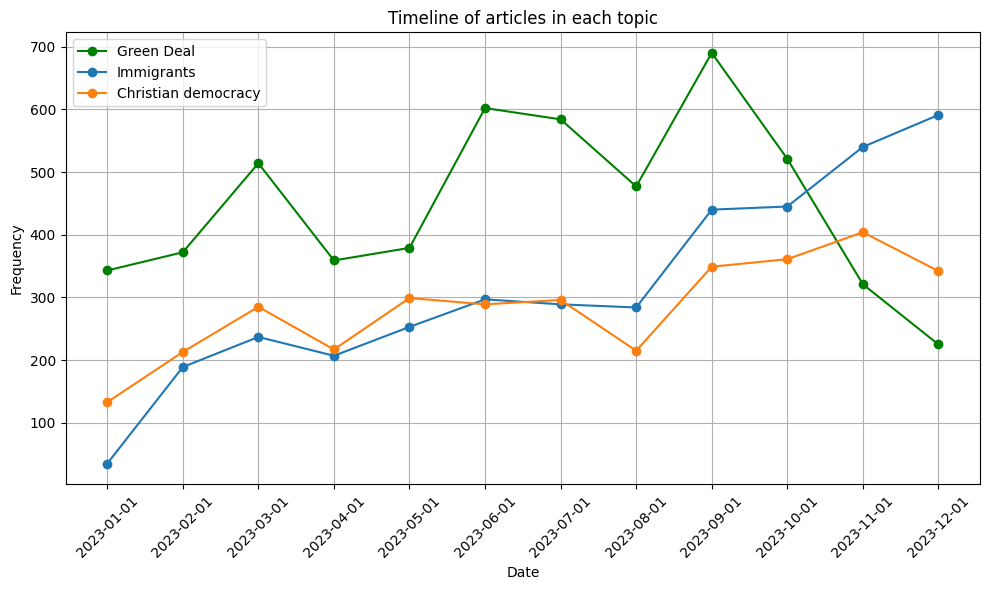

In [37]:
df = pd.read_parquet('df_w_entities_and_dates.parguet')
date_dict = dict(zip(df['url'], df['date_formatted']))
df_green_deal['publish_date'] = df_green_deal.url.apply(lambda x: date_dict[x].date())

summed_dict = {}

for label, df in  zip(['green_deal', 'immigrants', 'christian_democracy'], [df_green_deal, df_immigrants, df_christian]):
    df = df[df.publish_date.apply(lambda x: x is not None and x.year == 2023)]
    temp_dict = create_data_for_ts(df)
    summed_dict.update({label : temp_dict})
    

# Create the timeline plot
plt.figure(figsize=(10, 6))
plt.plot(summed_dict['green_deal'].keys(), summed_dict['green_deal'].values(), marker='o', linestyle='-', label = 'Green Deal', color = 'green')
plt.plot(summed_dict['immigrants'].keys(), summed_dict['immigrants'].values(), marker='o', linestyle='-', label = 'Immigrants')
plt.plot(summed_dict['christian_democracy'].keys(), summed_dict['christian_democracy'].values(), marker='o', linestyle='-', label='Christian democracy')

# Format the plot
plt.title(f'Timeline of articles in each topic')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')  # Adjust the location as needed
plt.tight_layout()
plt.savefig('time_series_overlap_topics_corrected.jpg')

# Display the plot
plt.show()


In [26]:
summed_dict['christian_democracy'].values()

dict_values([7, 10, 11, 3, 7, 18, 6, 17, 7, 12, 18, 4, 5])

In [5]:
top_persons_green_deal = [x[0] for x in Counter([item for sublist in list(df_green_deal['persons_ner_normalized_unique']) for item in sublist]).most_common(50) ]
top_persons_immigrants = [x[0] for x in Counter([item for sublist in list(df_immigrants['persons_ner_normalized_unique']) for item in sublist]).most_common(50) ]
top_persons_christian = [x[0] for x in Counter([item for sublist in list(df_christan['persons_ner_normalized_unique']) for item in sublist]).most_common(50)]
common_top_persons = set(top_persons_green_deal).intersection(set(top_persons_immigrants)).intersection(top_persons_christian)
common_top_persons

{'Annalena Baerbock',
 'Donald Trump',
 'Emmanuel Macron',
 'Giorgia Meloni',
 'Keir Starmer',
 'Manfred Weber',
 'Mark Rutte',
 'Olaf Scholz',
 'Pedro Snchez',
 'Recep Tayyip Erdogan',
 'Rishi Sunaks',
 'Suella Braverman',
 'Ursula Von Der Leyen',
 'Viktor Orbn',
 'Vladimir Putin',
 'Volodymyr Zelenskyy'}

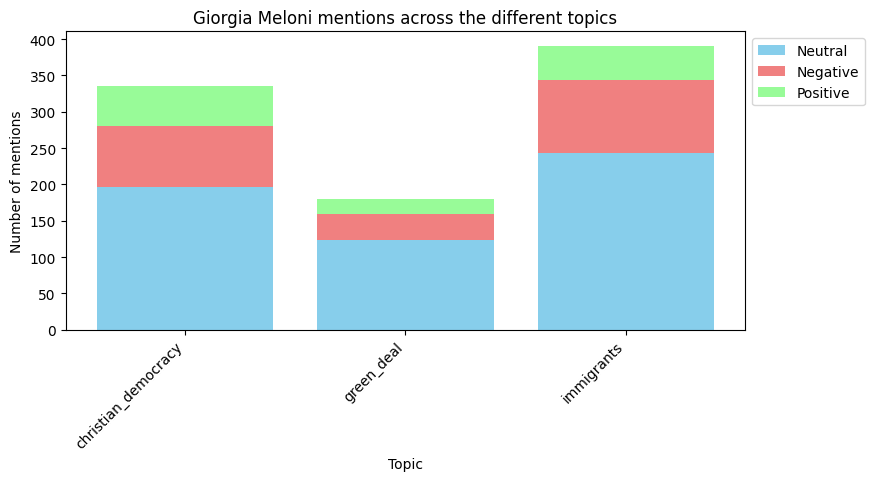

In [171]:
sample_name = 'Giorgia Meloni'

temp_df = merged_df[merged_df.persons_ner_normalized_unique.apply(lambda x: sample_name in x)]

sentiment_df_dict = {}

for sentiment_type in temp_df['sentiment'].unique():
    if sentiment_type == None:
        continue
    
    plot_df = temp_df[temp_df.sentiment == sentiment_type].groupby(['topic']).agg(list).reset_index()
    plot_df['url_num'] = plot_df.url.apply(lambda x: len(set(x)))
    sentiment_df_dict.update({'labels': list(plot_df['topic'])})
    sentiment_df_dict.update({sentiment_type : list(plot_df['url_num'])})
    

labels = data['labels']
neutral_values = data['neutral']
negative_values = data['negative']
positive_values = data['positive']

# Create positions for bars
x = np.arange(len(labels))

# Create the stacked bar chart
plt.bar(x, neutral_values, label='Neutral', color='skyblue')
plt.bar(x, negative_values, bottom=neutral_values, label='Negative', color='lightcoral')
plt.bar(x, positive_values, bottom=np.add(neutral_values, negative_values), label='Positive', color='palegreen')

# Customize the plot
plt.xlabel('Topic')
plt.ylabel('Number of mentions')
plt.title(f'{sample_name} mentions across the different topics')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)

plt.show()


In [175]:
sample_name = list(common_top_persons)[1]
distinct_topic_list = list(merged_df['topic'].unique())



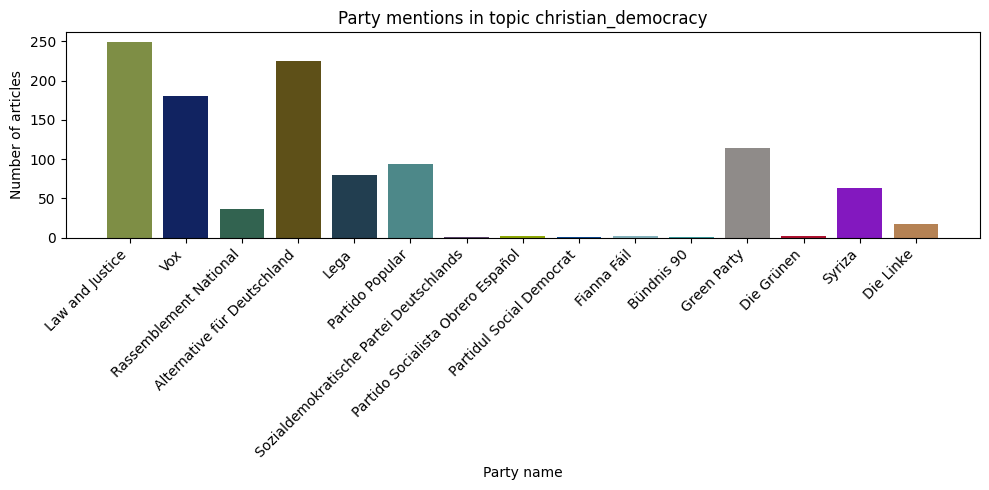

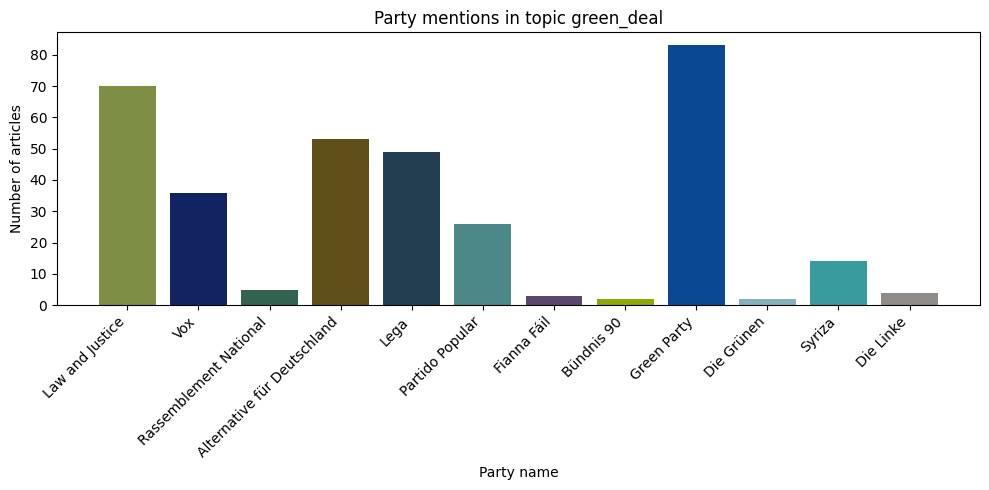

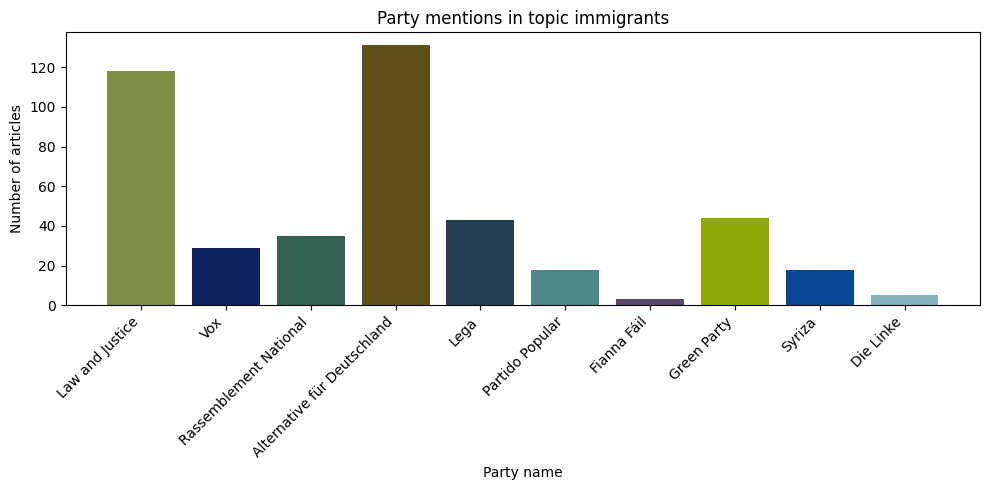

In [186]:
col = 'parties'
aggregation = 'Party'

for topic in distinct_topic_list:
    party_mention_dict = {}
    for party in [item for sublist in parties_list for item in sublist]:
        merged_df_temp = merged_df[merged_df.topic == topic]
        url_num = merged_df_temp[merged_df_temp[col].apply(lambda x: party in x)]['url'].nunique()
        if url_num > 0:
            party_mention_dict.update({ party.strip() : url_num})

    create_parties_plot(party_mention_dict, topic, aggregation )
#print(topic)

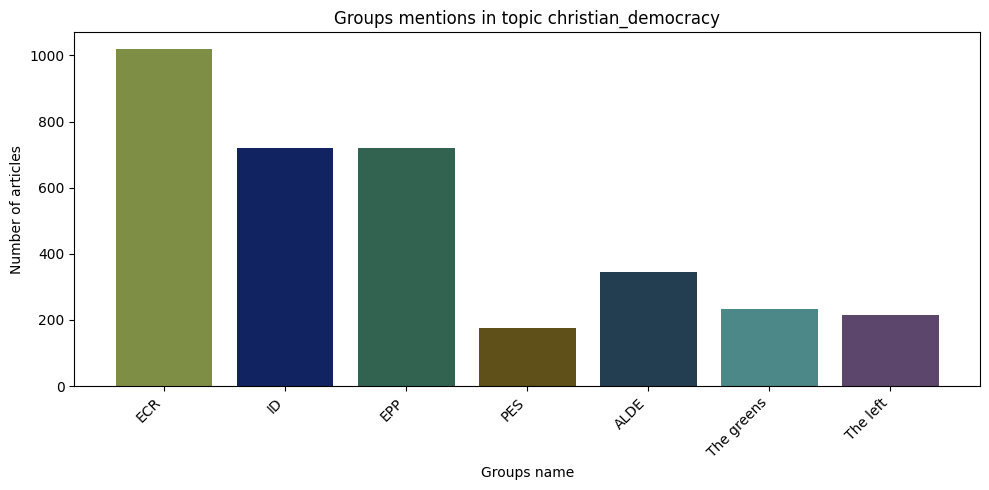

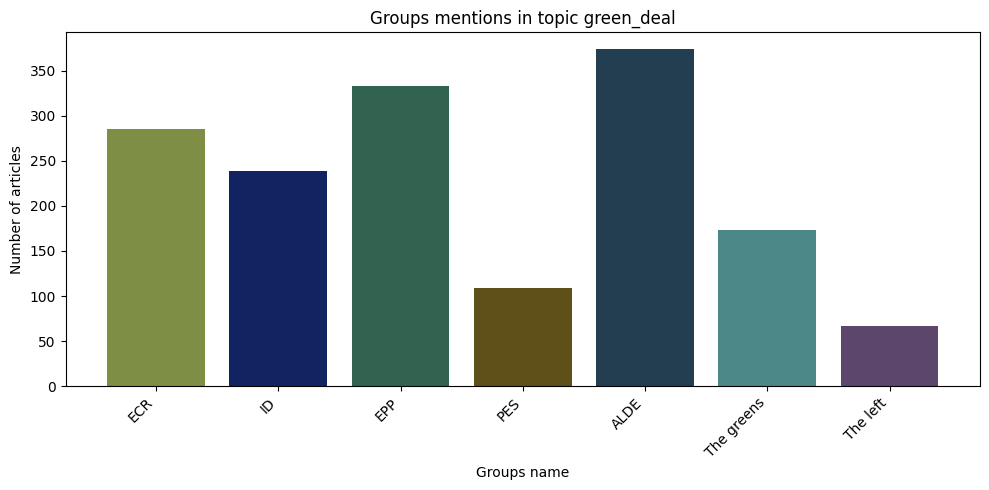

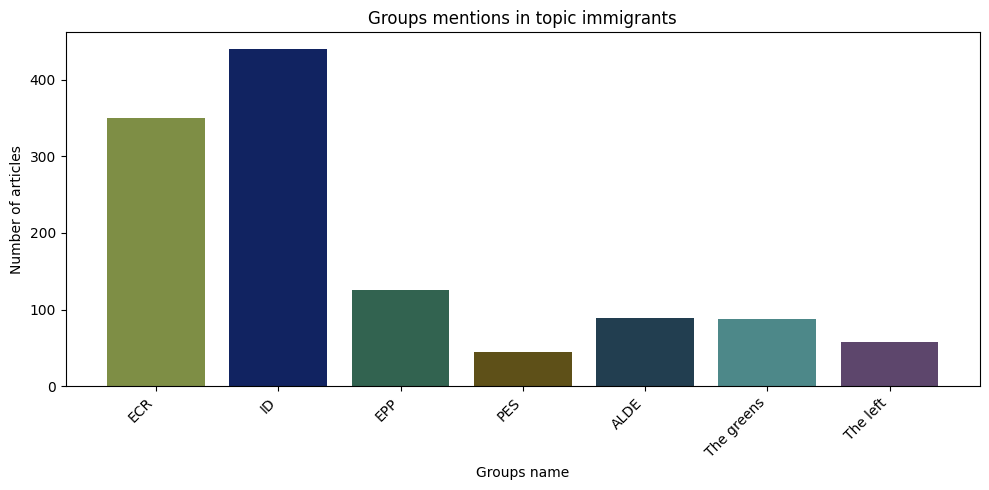

In [187]:
col = 'parties'

for topic in distinct_topic_list:
    
    group_mention_dict = {}
    aggregation = 'Groups'

    for key, value in parties_dict.items():
        group_mention_dict[key] = 0

        merged_df_temp = merged_df[merged_df.topic == topic]
        url_num = merged_df_temp[merged_df_temp['groups'].apply(lambda x: key in x)]['url'].nunique()
        group_mention_dict[key] += url_num

        for party in value:
            merged_df_temp = merged_df[merged_df.topic == topic]
            url_num = merged_df_temp[merged_df_temp[col].apply(lambda x: party in x)]['url'].nunique()
            if url_num > 0:
                group_mention_dict[key] += url_num

    create_parties_plot(group_mention_dict, topic, aggregation)


# PARTIES SPIDER CHARTS


In [172]:
filtered_df = merged_df[merged_df.parties.apply(lambda x: len(x) > 0)]
parties_df = pd.DataFrame(columns=['score', 'topic', 'sentiment', 'url', 'party'])

for i in  tqdm(range(len(filtered_df))):
    for party in filtered_df.iloc[i]['parties']:
        altered_row = [filtered_df.iloc[i].score, filtered_df.iloc[i].topic, filtered_df.iloc[i].sentiment, filtered_df.iloc[i].url, party]
        parties_df.loc[len(parties_df)] = altered_row

100%|█████████████████████████████████████████████████████████████████████████████| 9814/9814 [01:17<00:00, 126.35it/s]


In [199]:
theta_column = "party"
r_column = 'url_num'
for topic in distinct_topic_list:
    
    plot_df_positive = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == 'positive')].groupby('party').agg(set).reset_index()
    plot_df_negative = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == 'negative')].groupby('party').agg(set).reset_index()
    plot_df_neutral = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == 'neutral')].groupby('party').agg(set).reset_index()

    # Combine the positive and negative DataFrames
    combined_df = pd.concat([plot_df_positive, plot_df_negative])

    # Create a new column to indicate sentiment type
    combined_df['sentiment'] = ['Positive'] * len(plot_df_positive) + ['Negative'] * len(plot_df_negative)
    combined_df['url_num'] = combined_df.url.apply(lambda x: len(x))
    # Plot the spider chart
    title = f'Number of  mentions in articles of the different <br>political parties in topic {topic}'

    fig = px.line_polar(combined_df, r=r_column, theta=theta_column, color='sentiment',
                        line_close=True, title=title)

    fig.update_traces(fill='toself')

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                range=[min(combined_df[r_column]) - 1, max(combined_df[r_column]) + 1]
            )
        )
    )
    fig.update_layout(
    legend=dict(
        x=0.9,  # Adjust the x-coordinate (0 to 1) to position the legend horizontally
        y=0.9,  # Adjust the y-coordinate (0 to 1) to position the legend vertically
        bgcolor='rgba(255, 255, 255, 0.7)',  # Set a background color for the legend
        bordercolor='gray',  # Set a border color for the legend
        borderwidth=1,  # Set the border width
    )
)
    fig.show()
    fig_title = f'plots_new/parties_spider_chart_{topic}.jpg'
    fig.write_image(fig_title, format='jpeg', width=1200, height=800)



In [ ]:
topic = distinct_topic_list[0]
sentiment_type = 'positive'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')

sentiment_type = 'negative'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')

sentiment_type = 'neutral'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')
print(fig_title)

In [ ]:
topic = distinct_topic_list[1]
sentiment_type = 'positive'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')



sentiment_type = 'negative'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')



sentiment_type = 'neutral'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')


In [ ]:
topic = distinct_topic_list[2]
sentiment_type = 'positive'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')



sentiment_type = 'negative'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')


sentiment_type = 'neutral'
plot_df = parties_df[(parties_df.topic == topic) & (parties_df.sentiment == sentiment_type)].groupby('party').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'party', title)
print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart.jpg'
fig.write_image(fig_title, format='jpeg')


# GROUPS SPIDER CHARTS

In [179]:
filtered_df = merged_df[merged_df.groups.apply(lambda x: len(x) > 0)]
groups_df = pd.DataFrame(columns=['score', 'topic', 'sentiment', 'url', 'group'])

for i in  tqdm(range(len(filtered_df))):
    for party in filtered_df.iloc[i]['groups']:
        altered_row = [filtered_df.iloc[i].score, filtered_df.iloc[i].topic, filtered_df.iloc[i].sentiment, filtered_df.iloc[i].url, party]
        groups_df.loc[len(groups_df)] = altered_row


100%|███████████████████████████████████████████████████████████████████████████| 18708/18708 [01:41<00:00, 184.31it/s]


In [200]:
theta_column = "group"
r_column = 'url_num'
for topic in distinct_topic_list:
    
    plot_df_positive = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == 'positive')].groupby(theta_column).agg(set).reset_index()
    plot_df_negative = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == 'negative')].groupby(theta_column).agg(set).reset_index()
    plot_df_neutral = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == 'neutral')].groupby(theta_column).agg(set).reset_index()

    # Combine the positive and negative DataFrames
    combined_df = pd.concat([plot_df_positive, plot_df_negative])

    # Create a new column to indicate sentiment type
    combined_df['sentiment'] = ['Positive'] * len(plot_df_positive) + ['Negative'] * len(plot_df_negative)
    combined_df['url_num'] = combined_df.url.apply(lambda x: len(x))
    # Plot the spider chart
    title = f'Number of  mentions in articles of the different <br>political parties in topic {topic}'

    fig = px.line_polar(combined_df, r=r_column, theta=theta_column, color='sentiment',
                        line_close=True, title=title)

    fig.update_traces(fill='toself')

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                range=[min(combined_df[r_column]) - 1, max(combined_df[r_column]) + 1]
            )
        )
    )
    fig.update_layout(
    legend=dict(
        x=0.9,  # Adjust the x-coordinate (0 to 1) to position the legend horizontally
        y=0.9,  # Adjust the y-coordinate (0 to 1) to position the legend vertically
        bgcolor='rgba(255, 255, 255, 0.7)',  # Set a background color for the legend
        bordercolor='gray',  # Set a border color for the legend
        borderwidth=1,  # Set the border width
    )
)

    fig.show()

    fig_title = f'plots_new/groups_spider_chart_{topic}.jpg'
    fig.write_image(fig_title, format='jpeg', width=1200, height=800)



In [ ]:
topic = distinct_topic_list[0]
sentiment_type = 'positive'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == sentiment_type)].groupby('group').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'group', title)
#print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart_groups.jpg'
fig.write_image(fig_title, format='jpeg')



sentiment_type = 'negative'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == sentiment_type)].groupby('group').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'group', title)
#print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart_groups.jpg'
fig.write_image(fig_title, format='jpeg')


sentiment_type = 'neutral'
#plot_df = temp_df[temp_df.sentiment == 'positive'].groupby(['topic']).mean().reset_index()
plot_df = groups_df[(groups_df.topic == topic) & (groups_df.sentiment == sentiment_type)].groupby('group').agg(set).reset_index()
plot_df['url_num'] = plot_df.url.apply(lambda x: len(x))
title = f'Number of {sentiment_type} mentions in articles of the different <br>political groups in topic {topic}'
fig = create_spider_chart(plot_df, 'url_num', 'group', title)
#print(fig.show())
fig_title = f'plots/{topic}_{sentiment_type}_spider_chart_groups.jpg'
fig.write_image(fig_title, format='jpeg')


In [201]:
TITLE = "plots_new/parties_and_political_groups_20240215.pdf"

files = glob.glob('plots_new/**/*.png', recursive=True) + glob.glob('plots_new/**/*.jpg', recursive=True)
images = []

for filename in tqdm(files):
    images.append(Image.open(filename))

images[0].save(TITLE, save_all=True, append_images=images[1:])


100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 666.45it/s]
